# Part 2: Base Modeling

In [1]:
import os
import pandas as pd
from xgboost import XGBRegressor


from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [2]:
general_path = globals()['_dh'][0]    #The path to the main folder

# read the dataset
data = pd.read_csv(os.path.join(general_path,"Btc_small.csv"))
data

,Date,Open
0,2014-09-17,465.864014
1,2014-09-18,456.859985
2,2014-09-19,424.102997
3,2014-09-20,394.673004
4,2014-09-21,408.084991
...,...,...
832,2016-12-27,908.354004
833,2016-12-28,934.830994
834,2016-12-29,975.125000
835,2016-12-30,972.534973


In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [4]:
# Calculate numerical representation of 'Date'
data['Date_numeric'] = (data.index - data.index.min()).days

# Function to apply cyclical encoding
def apply_cyclical_encoding(data, column):
    data[column + '_sin'] = np.sin(2 * np.pi * data[column] / data[column].max())
    data[column + '_cos'] = np.cos(2 * np.pi * data[column] / data[column].max())
    return data

data = apply_cyclical_encoding(data, 'Date_numeric')

In [5]:
data

,Open,Date_numeric,Date_numeric_sin,Date_numeric_cos
Date,,,,
2014-09-17,465.864014,0,0.000000e+00,1.000000
2014-09-18,456.859985,1,7.515701e-03,0.999972
2014-09-19,424.102997,2,1.503098e-02,0.999887
2014-09-20,394.673004,3,2.254541e-02,0.999746
2014-09-21,408.084991,4,3.005856e-02,0.999548
...,...,...,...,...
2016-12-27,908.354004,832,-3.005856e-02,0.999548
2016-12-28,934.830994,833,-2.254541e-02,0.999746
2016-12-29,975.125000,834,-1.503098e-02,0.999887


# Prediction With XGBoost

In [6]:
# get the train and test frames 
train_size = len(data) - 60
valid_lim = train_size

train = data[:train_size]
test = data[valid_lim:]

X_train = train[['Date_numeric_sin', 'Date_numeric_cos']]
Y_train = train['Open']

x_test = test[['Date_numeric_sin', 'Date_numeric_cos']]
y_test = test['Open']


In [7]:
xg_boost = XGBRegressor()
xg_boost.fit(X_train, Y_train)
pred_xg = xg_boost.predict(x_test)
pred_train_xg = xg_boost.predict(X_train)
rmse_xg = mean_squared_error(y_test, pred_xg, squared=False)
rmse_train_xg = mean_squared_error(Y_train, pred_train_xg, squared=False)

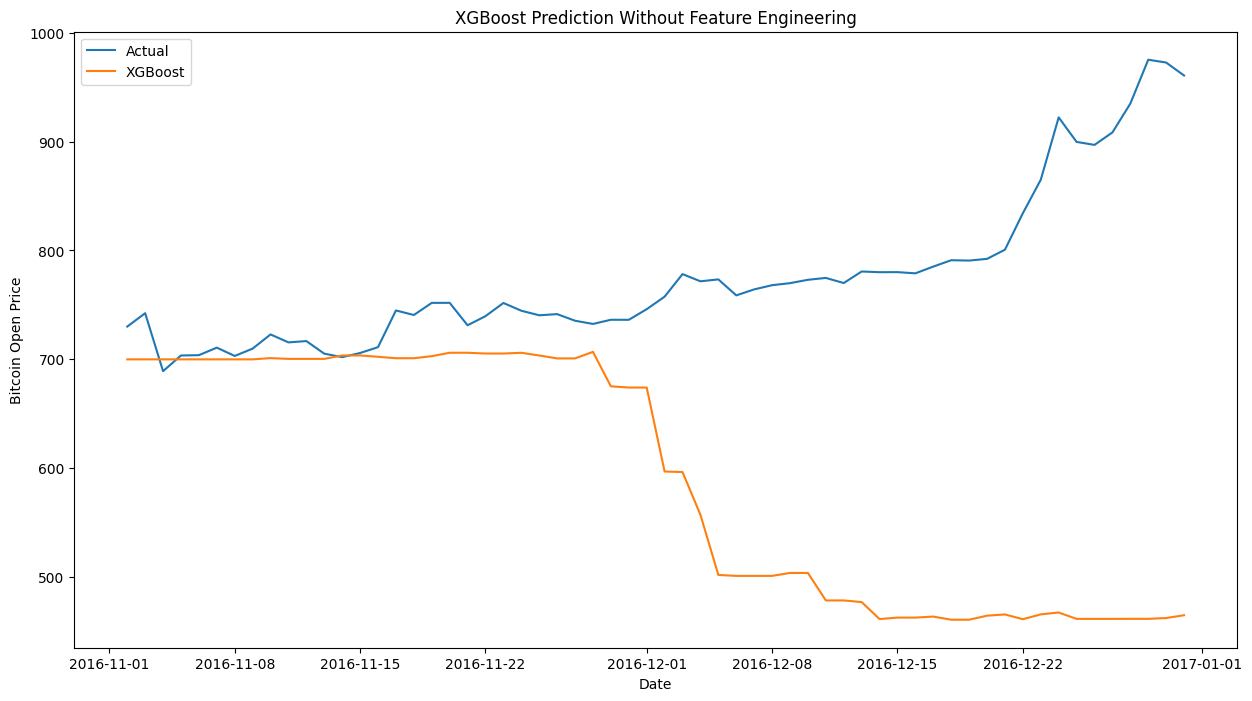

Naive Test: 16.0898826409532
***********************************************************************************
Root Mean Squared Error (Train - XGBoost): 1.7343066369455096
Root Mean Squared Error (XGBoost): 250.0209367775893


In [8]:
fig, ax = plt.subplots(figsize=(15, 8))


#plt.figure(figsize=(10, 8))
ax.plot(y_test.index, y_test, label='Actual')
ax.plot(y_test.index, pred_xg, label='XGBoost')
ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin Open Price')
ax.set_title('XGBoost Prediction Without Feature Engineering')
ax.legend()



plt.show()

naive_test = mean_squared_error(y_test,y_test.shift(1).bfill(), squared=False)
print("Naive Test:", naive_test)
print("***********************************************************************************")
#print("-----------------------------------------------------------------------------------")
print("Root Mean Squared Error (Train - XGBoost):", rmse_train_xg)
print("Root Mean Squared Error (XGBoost):", rmse_xg)

# Prediction With Neural Network

In [9]:
import torch
import matplotlib.pyplot as plt
import copy
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd

import numpy as np
import torch.nn as nn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import plotly.graph_objects as go

In [10]:
# Split the data into train, validation, and test sets
train_size = len(data) - 120
val_size = len(data) - 60
train = data[:train_size + 1]
valid = data[train_size:val_size + 1]
test = data[val_size:]

X_train = train[['Date_numeric_sin', 'Date_numeric_cos']]
Y_train = train['Open']

X_val = valid[['Date_numeric_sin', 'Date_numeric_cos']]
y_val = valid['Open']

x_test = test[['Date_numeric_sin', 'Date_numeric_cos']]
y_test = test['Open']

In [11]:
# Normalize the data using StandardScaler
mScalar = StandardScaler()
mScalar.fit(X_train)
X_train_scaled = mScalar.fit_transform(X_train)
X_val_scaled = mScalar.transform(X_val)
X_test_scaled = mScalar.transform(x_test)

# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_scaled).float()
X_val_tensor = torch.from_numpy(X_val_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float()

y_train_tensor = torch.from_numpy(Y_train.values).float() / 1000
y_val_tensor = torch.from_numpy(y_val.values).float() / 1000
y_test_tensor = torch.from_numpy(y_test.values).float() / 1000

In [12]:
# Define the MLP model class
class mMLP(torch.nn.Module):
    def __init__(self, input_dim, out_dim):
        super(mMLP, self).__init__()
        self.layer1 = torch.nn.Linear(input_dim, 32)
        self.layer2 = torch.nn.Linear(32, 32)
        self.layer3 = torch.nn.Linear(32, 32)
        self.layer4 = torch.nn.Linear(32, out_dim)

        self.act_func = torch.nn.LeakyReLU()

    def forward(self, x_):
        out1 = self.layer1(x_)
        out1 = self.act_func(out1)

        out1 = self.layer2(out1)
        out1 = self.act_func(out1)

        out1 = self.layer3(out1)
        out1 = self.act_func(out1)

        out1 = self.layer4(out1)
        return out1

In [13]:
# Seed for reproducibility
torch.manual_seed(42)

# Create the MLP model
mModel = mMLP(input_dim=X_train_tensor.shape[1], out_dim=1)

# Set the maximum number of epochs for training
MAX_EPOCH = 10000

# Create the optimizer and loss function
mOptimizer = torch.optim.Adam(params=mModel.parameters(), lr=3e-2)
mLoss = torch.nn.MSELoss()

# Lists to store training and validation losses during training
val_losses_list, train_losses_list = [], []

# Variables to keep track of the best model and the best validation loss
best_model = None
min_val_loss = np.inf

C:\Users\dor_b\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([718])) that is different to the input size (torch.Size([718, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\dor_b\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([61])) that is different to the input size (torch.Size([61, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch    0: Train Loss: 0.20300247 Val Loss: 0.11733834, Min Val Loss is at Epoch:    0, : 0.11733834
Epoch  100: Train Loss: 0.01660745 Val Loss: 0.07013498, Min Val Loss is at Epoch:    2, : 0.02711794
Epoch  200: Train Loss: 0.01660676 Val Loss: 0.07020657, Min Val Loss is at Epoch:    2, : 0.02711794
Epoch  300: Train Loss: 0.01660657 Val Loss: 0.07010701, Min Val Loss is at Epoch:    2, : 0.02711794
Epoch  400: Train Loss: 0.01660646 Val Loss: 0.07003519, Min Val Loss is at Epoch:    2, : 0.02711794
Epoch  500: Train Loss: 0.01660640 Val Loss: 0.06998503, Min Val Loss is at Epoch:    2, : 0.02711794
Epoch  600: Train Loss: 0.01660638 Val Loss: 0.06995080, Min Val Loss is at Epoch:    2, : 0.02711794
Epoch  700: Train Loss: 0.01660636 Val Loss: 0.06992782, Min Val Loss is at Epoch:    2, : 0.02711794
Epoch  800: Train Loss: 0.01660635 Val Loss: 0.06991217, Min Val Loss is at Epoch:    2, : 0.02711794
Epoch  900: Train Loss: 0.01660635 Val Loss: 0.06990110, Min Val Loss is at Epoch:

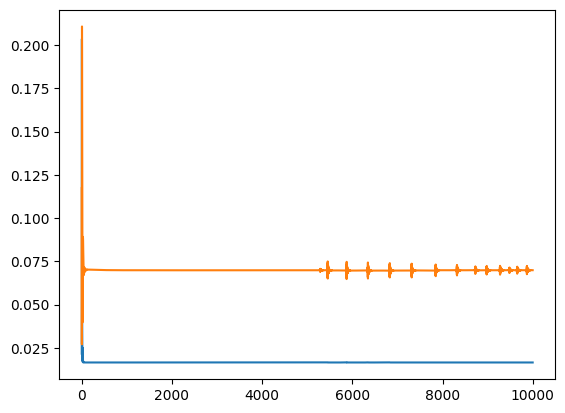

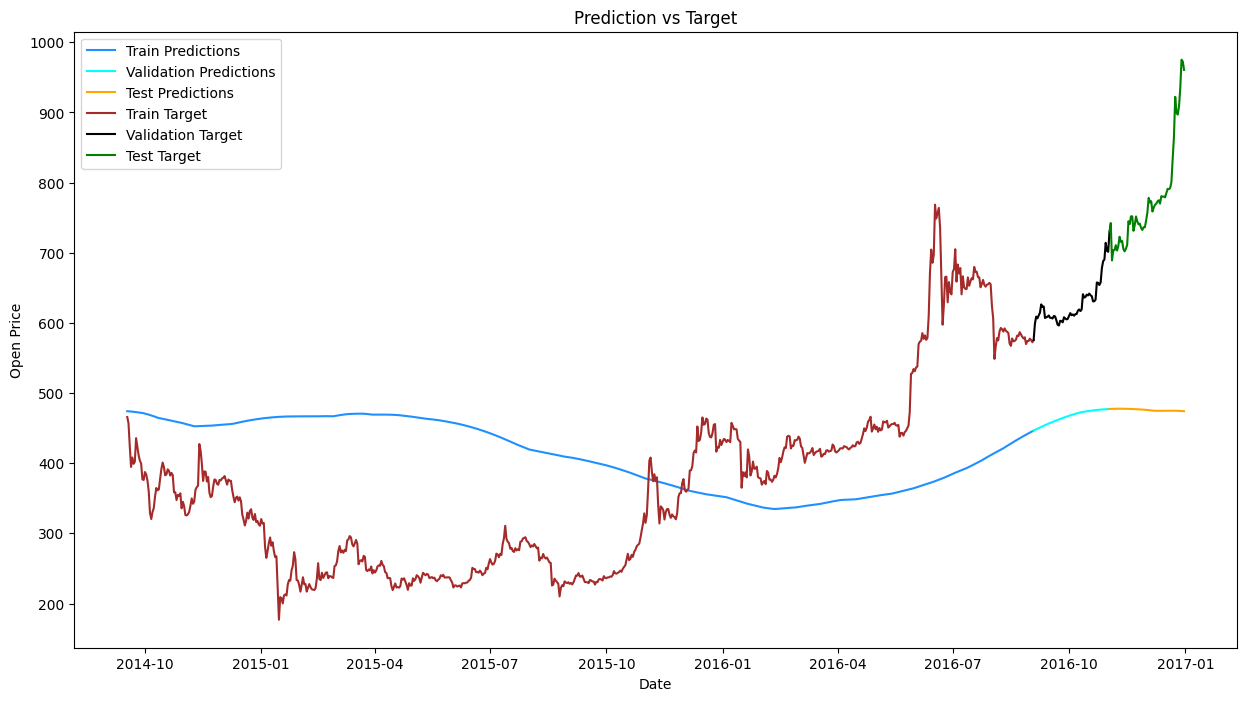

Train RMSE: 163.9926
Test RMSE: 307.6623
Train R2 Score: -0.6195
Test R2 Score: -17.7331


In [14]:
# Training loop
for epoch_indx in range(MAX_EPOCH):
    mModel.train()
    train_preds = mModel.forward(X_train_tensor)

    # Compute the training loss and store it
    loss = mLoss(train_preds, y_train_tensor)
    train_losses_list.append(loss.item())
    
    # Print the training loss every 100 epochs
    if epoch_indx % 100 == 0:
        print(f"Epoch {epoch_indx:4d}: Train Loss: {loss.item():.8f}", end=" ")

    # Perform backpropagation and update the model's parameters
    mOptimizer.zero_grad()
    loss.backward()
    mOptimizer.step()

    # Validation
    with torch.no_grad():
        mModel.eval()
        val_preds = mModel.forward(X_val_tensor)
        val_loss = mLoss(val_preds, y_val_tensor)
        val_losses_list.append(val_loss.item())

        # Print the validation loss and update the best model
        if epoch_indx % 100 == 0:
            min_val_loss_index = np.argmin(np.asarray(val_losses_list))
            min_val_loss = np.min(np.asarray(val_losses_list))
            print(f"Val Loss: {val_loss.item():.8f}, Min Val Loss is at Epoch: {min_val_loss_index:4d}, : {min_val_loss:.8f}")    
        
        if min_val_loss > val_loss.item():
            min_val_loss = val_loss.item()
            best_model = copy.deepcopy(mModel)

# Plot the training and validation losses
plt.plot(train_losses_list)
plt.plot(val_losses_list)
plt.show()

# Perform predictions using the best model on train, validation, and test sets
with torch.no_grad():
    train_preds = best_model.forward(X_train_tensor).numpy() * 1000
    train_preds = pd.DataFrame(train_preds, index=X_train.index)
    
    val_preds = best_model.forward(X_val_tensor).numpy() * 1000
    val_preds = pd.DataFrame(val_preds, index=X_val.index)
    
    test_preds = best_model.forward(X_test_tensor).numpy() * 1000
    test_preds = pd.DataFrame(test_preds, index=x_test.index)

# Calculate RMSE for train and test sets
train_rmse = np.sqrt(mean_squared_error(Y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

# Calculate R2 score for train and test sets
train_r2 = r2_score(Y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

# Create the plot
fig, ax = plt.subplots(figsize=(15, 8))

# Add data series to the plot
ax.plot(train_preds.index, train_preds[0], label="Train Predictions", color='dodgerblue')
ax.plot(val_preds.index, val_preds[0], label="Validation Predictions", color='cyan')
ax.plot(test_preds.index, test_preds[0], label="Test Predictions", color='orange')
ax.plot(pd.DataFrame(Y_train).index, pd.DataFrame(Y_train)["Open"], label="Train Target", color='brown')
ax.plot(pd.DataFrame(y_val).index, pd.DataFrame(y_val)["Open"], label="Validation Target", color='black')
ax.plot(pd.DataFrame(y_test).index, pd.DataFrame(y_test)["Open"], label="Test Target", color='green')

# Customize the plot
ax.set_title('Prediction vs Target')
ax.set_xlabel('Date')
ax.set_ylabel('Open Price')
ax.legend()

# Display the plot

plt.show()



print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train R2 Score: {train_r2:.4f}")
print(f"Test R2 Score: {test_r2:.4f}")